In [2]:
from folktables import ACSDataSource
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import folktables
import numpy as np
import pickle
from bestLS_hindsight import *
from OnlineRidgeRiver import *
from lean_adahedge import *
import matplotlib.pyplot as plt
from bestLS_hindsight_together import *
from oridge_alwaysactive_implementable import *


from folktables.load_acs import state_list

In [3]:
def plot_ORidgevsAnh_together(cumreg_groupwise_oridge, Anh):
  Anhbetter_count = 0
  N = len(Anh.cuml_regret_curve)
  for gnum in range(N):  
    oridge_regret_g = cumreg_groupwise_oridge[gnum]
    Tg = len(oridge_regret_g) # number of rounds this group is active
    Anh_end = Anh.cuml_regret_curve[gnum][-1] # last time steps cumulative regret
    oridge_end = oridge_regret_g[-1]
    if Anh_end <= oridge_end:
      Anhst = "Yes"
      Anhbetter_count += 1
    else:
      Anhst = "No"
    print(f'''Group number {gnum}, Tg is {Tg} \n
    oridge end regret {oridge_end:.2f}, Anh end regret {Anh_end:.2f}, \n
    Anh better {Anhst} ''')
    time_steps = np.arange(1, Tg+1)
    plt.plot(time_steps, cumreg_groupwise_oridge[gnum],'-b', label="Online Ridge (OR)")
    plt.plot(time_steps, Anh.cuml_regret_curve[gnum], '-r', label="Anh with OR meta experts")
    plt.xlabel("Time slots")
    plt.ylabel("Regret")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
  print(f'Anh better for {Anhbetter_count} out of {N} groups') # caught a bug here!

In [ ]:
# Implementable Version

# with open('loss_oridge_all_alwaysactive.pkl', 'rb') as f:
#     loss_tarr = pickle.load(f)

# loss_groupwise_oridge = []
# cumloss_groupwise_oridge = []
# cumreg_groupwise_oridge = []
# loss_oridge_tarr = np.array(loss_tarr)

# for gnum in range(N): # build cumulative loss for  on each group subsequence
#     loss_groupwise_oridge.append(loss_oridge_tarr[A_tarr[:, gnum].astype(bool)]) # select those losses where group gnum active
#     cumloss_groupwise_oridge.append(np.cumsum(loss_groupwise_oridge[-1])) #cumulative sum of the previous
#     cumreg_groupwise_oridge.append(cumloss_groupwise_oridge[-1] - bls_undrop.best_sqloss[gnum]) #bestsquare loss for that group subsequence still the same

In [21]:
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, TargetEncoder, StandardScaler, OneHotEncoder
def numeric_scaler(df, cols):
    '''
    df: pandas dataframe
    numeric_cols: (array of strings) column names for numeric variables

    no return: does inplace operation
    '''
    df_new = df.copy()
    mmscaler = MinMaxScaler()
    df_new[cols] = mmscaler.fit_transform(df_new[cols])
    return df_new

def ordinal_encoder(df, cols): # similar to label encoder which only works for targets?
    '''
    Encode categorical into 0 ... n-1
    '''
    df_new = df.copy()
    ordinal_enc = OrdinalEncoder()
    df_new[cols] = ordinal_enc.fit_transform(df_new[cols])
    return df_new

def oh_sklearn(df, cols):
    pass
    # Issues with this operation as it doesnt preseve number of columns etc, the dummies method below works
    # df_new = df.copy()
    # oh_enc = OneHotEncoder()
    # df_new[cols] = oh_enc.fit_transform(df_new[cols])
    # return df_new

def one_hot(df, cols): # idk if sklearns one-hot encoder is similar
    """
    df: pandas DataFrame
    param: cols a list of columns to encode 
    return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

def target_encoder(df, x_cols, y_col):
    df_new = df.copy()
    enc_auto = TargetEncoder(smooth="auto", target_type="continuous")
    df_new[x_cols] = enc_auto.fit_transform(df_new[x_cols], df[y_col])
    return df_new

def target_encoder2(df, x_cols, y_col):
    df_new = df.copy()
    enc_auto = TargetEncoder(smooth="auto", target_type="continuous")
    df_new[x_cols] = enc_auto.fit_transform(df_new[x_cols], df[y_col])
    return df_new, enc_auto

In [22]:
# Ira Globus code schema
ACSIncome = folktables.BasicProblem(
    features=[
        "ST", # state
        "AGEP",  # age of householder 
        "CIT", # citizenship status categoric 1 to 5
        "COW", # class of worker categoric
        "DDRS", # self-care difficulty
        "DEAR", # hearing difficulty
        "DEYE", # vision difficulty
        "DOUT", #independent living difficulty
        "DRAT", # veteran disability 
        "DREM", # cognitive difficulty
        "ENG", #Ability to speak english
        "FER", #Gave birth to child in last 12 months
        "JWTRNS", # means of transport to work
        "LANX", # language spoken other than english
        "MAR", # marital status
        "MIL", # military service
        "OCCP", # occupation
        'POBP', #place of birth, US states, and if international has places
        'RELSHIPP', #Relationship, renamed to Relantioship in the new PUMS syntax, 20 - 38
        "SCHL", # educational attainment
        "SEX", # Sex
        'WKHP', # number of hours worked per week
        "RAC1P" # race

    target='PINCP',
    # target_transform=lambda x: x > 50000,    
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

all_cols_ira=[
        "ST", # state
        "AGEP",  # age of householder 
        "CIT", # citizenship status categoric 1 to 5
        "COW", # class of worker categoric
        "DDRS", # self-care difficulty
        "DEAR", # hearing difficulty
        "DEYE", # vision difficulty
        "DOUT", #independent living difficulty
        "DRAT", # veteran disability 
        "DREM", # cognitive difficulty
        "ENG", #Ability to speak english
        "FER", #Gave birth to child in last 12 months
        "JWTRNS", # means of transport to work
        "LANX", # language spoken other than english
        "MAR", # marital status
        "MIL", # military service
        "OCCP", # occupation
        'POBP', #place of birth, US states, and if international has places
        'RELSHIPP', #Relationship, renamed to Relantioship in the new PUMS syntax, 20 - 38
        "SCHL", # educational attainment
        "SEX", # Sex
        'WKHP', # number of hours worked per week
        "RAC1P" # race
    ]
cat_cols_ira=[
        "ST", # state
        "CIT", # citizenship status categoric 1 to 5
        "COW", # class of worker categoric
        "DDRS", # self-care difficulty
        "DEAR", # hearing difficulty
        "DEYE", # vision difficulty
        "DOUT", #independent living difficulty
        "DRAT", # veteran disability 
        "DREM", # cognitive difficulty
        "ENG", #Ability to speak english
        "FER", #Gave birth to child in last 12 months
        "JWTRNS", # means of transport to work
        "LANX", # language spoken other than english
        "MAR", # marital status
        "MIL", # military service
        "OCCP", # occupation
        'POBP', #place of birth, US states, and if international has places
        'RELSHIPP', #Relationship, renamed to Relantioship in the new PUMS syntax, 20 - 38
        "SCHL", # educational attainment
        "SEX", # Sex
        "RAC1P" # race
    ]
# all_cols_ira = ["ST", "AGEP", "CIT", "COW", "DDRS", "DEAR", "DEYE","DOUT", 
#  "DRAT","DREM","ENG","FER","JWTRNS","LANX","MAR","MIL","SCHL","SEX",'WKHP',"OCCP","RAC1P"]
# cat_cols_ira = ["ST", "CIT", "COW", "DDRS", "DEAR", "DEYE", "DOUT", 
#  "DRAT","DREM","ENG","FER","JWTRNS","LANX","MAR","MIL","SCHL","SEX","OCCP","RAC1P"]

print('Selected states: ', state_list)
data_source = ACSDataSource(survey_year='2021', horizon='1-Year', survey='person')
acs_data = data_source.get_data(state_list, download=True)

X, y, gr = ACSIncome.df_to_pandas(acs_data)
dataset = pd.concat([X, y], axis=1)

for catg in cat_cols_ira:
    dataset[catg] = dataset[catg].astype(int)

Selected states:  ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR']


In [10]:
data_incomeless200k = dataset[dataset['PINCP'] <= 2e5]
data_fil = data_incomeless200k
# top_200OCCP = dataset['OCCP'].value_counts()[:250].index.tolist() # top 200 occupation codes in the original dataframe
# data_fil = data_incomeless200k[data_incomeless200k['OCCP'].isin(top_200OCCP)]
print(len(data_fil) / len(dataset)) #top200 occp codes and <= 200k is 83 % of original dataset

NameError: name 'dataset' is not defined

In [24]:
# target encodings followed by minmax scaling all, just using TRAIN DATA
# categorical_cols = ['COW','SCHL', 'MAR', 'OCCP', 'POBP', 'RELSHIPP', 'SEX', 'RAC1P']
df_te, te_trfit = target_encoder2(data_fil, cat_cols_ira, ['PINCP']) # returns modified dataframe as well as target encoder object which has learnt the transformation
df_te_scaled = numeric_scaler(df_te, df_te.columns)

# df_te_scaled.head()

X_dat_te_scaled = df_te_scaled.drop('PINCP', axis=1) #dropping the income column
y_dat_te_scaled = pd.DataFrame(df_te_scaled['PINCP']) # picking up only the income column for the target

model_lr_te_scaled = LinearRegression(n_jobs = -1)
model_lr_te_scaled.fit(X_dat_te_scaled, y_dat_te_scaled)
print(f"LR score on target encoding and scaled {model_lr_te_scaled.score(X_dat_te_scaled, y_dat_te_scaled)}")

model_ridge_te_scaled = Ridge()
model_ridge_te_scaled.fit(X_dat_te_scaled, y_dat_te_scaled)
print(f"Ridge score on target encoding and scaled {model_ridge_te_scaled.score(X_dat_te_scaled, y_dat_te_scaled)}")

model_lasso_te_scaled = Lasso() # kinda garbage , all zeros for weight?
model_lasso_te_scaled.fit(X_dat_te_scaled, y_dat_te_scaled)
print(f"Lasso score on target encoding and scaled {model_lasso_te_scaled.score(X_dat_te_scaled, y_dat_te_scaled)}")

#TODO try r2 scores on some unseen data, using transform, dont do fit transform from target_encoder!

/Users/krisacha/anaconda3/envs/multigroup/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR score on target encoding and scaled 0.4896998560342698
Ridge score on target encoding and scaled 0.48969985590601717
Lasso score on target encoding and scaled 0.0


In [35]:
df_te_scaled.head()

,ST,AGEP,CIT,COW,DDRS,DEAR,DEYE,DOUT,DRAT,DREM,...,MAR,MIL,OCCP,POBP,RELSHIPP,SCHL,SEX,WKHP,RAC1P,PINCP
0,0.525138,0.025316,0.699685,0.636884,1.000000,0.008370,1.000000,1.000000,0.000478,1.000000,...,0.000573,0.058166,0.177933,0.446079,0.032310,0.304906,0.004920,0.295918,0.727234,0.039472
1,0.523853,0.037975,0.698391,0.567918,0.999287,0.004472,0.998455,0.999358,0.000093,0.999546,...,0.001507,0.057390,0.019652,0.305960,0.033118,0.301826,0.998032,0.397959,0.185184,0.030967
2,0.523532,0.025316,0.699339,0.636352,0.998900,0.002442,0.998835,0.999420,0.000068,0.999710,...,0.002266,0.056633,0.200153,0.365174,0.031053,0.305734,0.003923,0.173469,0.727165,0.030467
3,0.525138,0.215190,0.699685,0.636884,1.000000,0.008370,1.000000,1.000000,0.000478,1.000000,...,0.693236,0.058166,0.144017,0.368449,0.032310,0.300943,0.004920,0.051020,0.727234,0.053479
4,0.525138,0.025316,0.699685,0.568282,1.000000,0.905686,1.000000,1.000000,0.000478,1.000000,...,0.000573,0.058166,0.173344,0.517242,0.032310,0.304906,0.995550,0.091837,0.727234,0.009455


[0.37004341 0.31782055 0.16467267 0.13133644 0.13077509 0.09516973
 0.07951726 0.06574526 0.05313839 0.04790992 0.03525211 0.03224682
 0.01922402 0.01409053 0.01280999]
Index(['OCCP', 'WKHP', 'AGEP', 'SCHL', 'ST', 'JWTRNS', 'DRAT', 'COW', 'SEX',
       'RELSHIPP', 'POBP', 'ENG', 'MAR', 'RAC1P', 'DREM'],
      dtype='object')
14


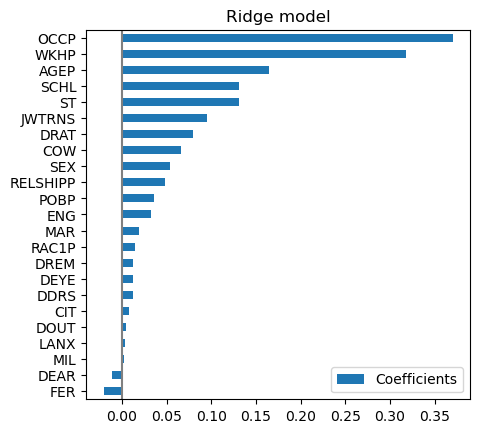

In [37]:
#plotting weights of the Linear regression model
w = model_lr_te_scaled.coef_.ravel()
col_names = X_dat_te_scaled.columns
ind_sort = np.argsort(w)

coefs = pd.DataFrame(
    w[ind_sort], columns=["Coefficients"], index = col_names[ind_sort]
)

# most important seem to be OCCP, WKHP, SCHL, AGEP, COW
coefs.plot(kind="barh")
plt.title("Ridge model")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

print(w[ind_sort][-15:][::-1])
print(col_names[ind_sort][-15:][::-1])

# just picking top 14 till RAC1P
sig_features = ['OCCP', 'WKHP', 'AGEP', 'SCHL', 'ST', 'JWTRNS', 'DRAT', 'COW', 'SEX',
       'RELSHIPP', 'POBP', 'ENG', 'MAR', 'RAC1P']
print(len(sig_features))

In [17]:
# Ira Globus code schema, and choosing only Significant features
ACSIncome = folktables.BasicProblem(
    features = ['OCCP', 'WKHP', 'AGEP', 'SCHL', 'ST', 'JWTRNS', 'DRAT', 'COW', 'SEX',
       'RELSHIPP', 'POBP', 'ENG', 'MAR', 'RAC1P'],
    target='PINCP',
    # target_transform=lambda x: x > 50000,    
    preprocess=folktables.adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

cat_cols_sig = ['OCCP', 'SCHL', 'ST', 'JWTRNS', 'DRAT', 'COW', 'SEX', 
       'RELSHIPP', 'POBP', 'ENG', 'MAR', 'RAC1P'] # significant features from the earlier analysis

print('Selected states: ', state_list)
data_source = ACSDataSource(survey_year='2021', horizon='1-Year', survey='person')
acs_data = data_source.get_data(state_list, download=True)

X, y, gr = ACSIncome.df_to_pandas(acs_data)
dataset = pd.concat([X, y], axis=1)

for catg in cat_cols_sig:
    dataset[catg] = dataset[catg].astype(int)

Selected states:  ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR']


In [18]:
data_incomeless200k = dataset[dataset['PINCP'] <= 2e5]
data_fil = data_incomeless200k
# top_200OCCP = dataset['OCCP'].value_counts()[:250].index.tolist() # top 200 occupation codes in the original dataframe
# data_fil = data_incomeless200k[data_incomeless200k['OCCP'].isin(top_200OCCP)]
print(len(data_fil) / len(dataset)) #top200 occp codes and <= 200k is 83 % of original dataset

0.9625934030071766


In [19]:
# target encodings followed by minmax scaling all, just using TRAIN DATA
# categorical_cols = ['COW','SCHL', 'MAR', 'OCCP', 'POBP', 'RELSHIPP', 'SEX', 'RAC1P']
df_te, te_trfit = target_encoder2(data_fil, cat_cols_sig, ['PINCP']) # returns modified dataframe as well as target encoder object which has learnt the transformation
df_te_scaled = numeric_scaler(df_te, df_te.columns)

# df_te_scaled.head()

X_dat_te_scaled = df_te_scaled.drop('PINCP', axis=1) #dropping the income column
y_dat_te_scaled = pd.DataFrame(df_te_scaled['PINCP']) # picking up only the income column for the target

model_lr_te_scaled = LinearRegression(n_jobs = -1)
model_lr_te_scaled.fit(X_dat_te_scaled, y_dat_te_scaled)
print(f"LR score on target encoding and scaled {model_lr_te_scaled.score(X_dat_te_scaled, y_dat_te_scaled)}")

model_ridge_te_scaled = Ridge()
model_ridge_te_scaled.fit(X_dat_te_scaled, y_dat_te_scaled)
print(f"Ridge score on target encoding and scaled {model_ridge_te_scaled.score(X_dat_te_scaled, y_dat_te_scaled)}")

model_lasso_te_scaled = Lasso() # kinda garbage , all zeros for weight?
model_lasso_te_scaled.fit(X_dat_te_scaled, y_dat_te_scaled)
print(f"Lasso score on target encoding and scaled {model_lasso_te_scaled.score(X_dat_te_scaled, y_dat_te_scaled)}")


/Users/krisacha/anaconda3/envs/multigroup/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LR score on target encoding and scaled 0.48857635272351296
Ridge score on target encoding and scaled 0.488576352607454
Lasso score on target encoding and scaled 0.0


[0.37717729 0.31919295 0.141394   0.13291921 0.13088284 0.09552601
 0.07993622 0.06453369 0.04937275 0.03989147 0.03721913 0.03466906
 0.02044875 0.01490949]
Index(['OCCP', 'WKHP', 'AGEP', 'SCHL', 'ST', 'JWTRNS', 'DRAT', 'COW',
       'RELSHIPP', 'SEX', 'ENG', 'POBP', 'MAR', 'RAC1P'],
      dtype='object')
14


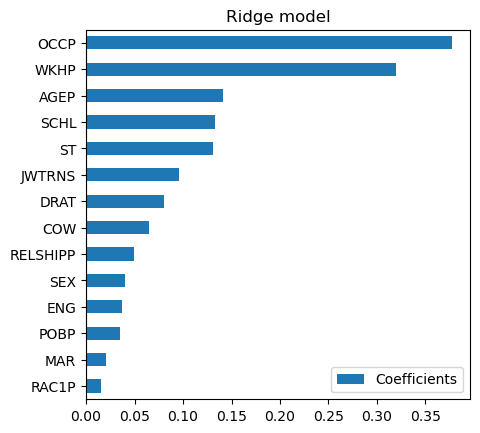

In [41]:
#plotting weights of the Linear regression model
w = model_lr_te_scaled.coef_.ravel()
col_names = X_dat_te_scaled.columns
ind_sort = np.argsort(w)

coefs = pd.DataFrame(
    w[ind_sort], columns=["Coefficients"], index = col_names[ind_sort]
)

# most important seem to be OCCP, WKHP, SCHL, AGEP, COW
coefs.plot(kind="barh")
plt.title("Ridge model")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

print(w[ind_sort][-15:][::-1])
print(col_names[ind_sort][-15:][::-1])

# just picking top 14 till RAC1P
sig_features = ['OCCP', 'WKHP', 'AGEP', 'SCHL', 'ST', 'JWTRNS', 'DRAT', 'COW', 'SEX',
       'RELSHIPP', 'POBP', 'ENG', 'MAR', 'RAC1P']
print(len(sig_features))

In [43]:
df_te_scaled.to_pickle("data_all_targetencoded_15cols") # also has < 200k annual income and top occupations 
del df_te_scaled

In [5]:
df_te_scaled = pd.read_pickle("./target_encoded/dataframes/data_all_targetencoded_15cols")
df_te_scaled # has < 200k annual income rest untouched, also picked top 15 columns, after using minimal example Ira bias bounties

,OCCP,WKHP,AGEP,SCHL,ST,JWTRNS,DRAT,COW,SEX,RELSHIPP,POBP,ENG,MAR,RAC1P,PINCP
0,0.174295,0.295918,0.025316,0.305521,0.525227,0.001086,0.000090,0.634268,0.003645,0.024891,0.440289,0.998451,0.001210,0.731267,0.039472
1,0.019586,0.397959,0.037975,0.303514,0.526608,0.440986,0.000244,0.566230,1.000000,0.023964,0.295825,0.998377,0.001598,0.189201,0.030967
2,0.198418,0.173469,0.025316,0.305698,0.531881,0.000343,0.000416,0.633992,0.003765,0.026136,0.364825,0.998644,0.001433,0.730600,0.030467
3,0.143561,0.051020,0.215190,0.302304,0.531881,0.410761,0.000416,0.633992,0.003765,0.026136,0.357630,0.998644,0.691216,0.730600,0.053479
4,0.169829,0.091837,0.025316,0.305521,0.525227,0.001086,0.000090,0.566516,0.995435,0.024891,0.512168,0.998451,0.001210,0.731267,0.009455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630162,0.584837,0.397959,0.291139,0.630562,0.002089,0.440826,0.000416,0.567354,0.003765,0.999952,0.097861,0.638492,0.001433,0.314840,0.399670
1630163,0.437459,0.397959,0.379747,0.806307,0.007309,0.440986,0.000861,0.637931,0.998820,1.000000,0.097829,0.254902,1.000000,0.314533,0.299615
1630164,0.232059,0.397959,0.367089,0.630562,0.002089,0.440826,0.000416,0.679348,0.003765,0.964693,0.097861,0.998644,0.998923,0.314840,0.092501
1630165,0.299907,0.295918,0.063291,0.630301,0.000000,0.857815,0.000244,0.360696,1.000000,0.276848,0.098585,0.641927,0.001598,0.315268,0.060483


In [7]:
from collections import Counter
Counter(df_te_scaled['SEX'])

Counter({0.0036446655103294923: 152754,
         1.0000000000000004: 161020,
         0.003764756505643785: 152640,
         0.9954349845115531: 161084,
         0.000816166474057578: 152786,
         0.004735010080934465: 152687,
         0.0: 152818,
         0.9978513237385331: 161051,
         0.9988196393486777: 161151,
         0.9973486960656879: 161197})

# Lets define the groups, - all senstive: Sex, Gender, always active

- Use another un encoded dataframe to get group and etc memberships? because the target encoded has lost what groups mean etc 
- One hot encode and bring back? to get all columns

In [20]:
data_fil # unencoded

,OCCP,WKHP,AGEP,SCHL,ST,JWTRNS,DRAT,COW,SEX,RELSHIPP,POBP,ENG,MAR,RAC1P,PINCP
0,4760,30.0,19.0,18,1,0,0,2,2,38,53,0,5,1,8000.0
1,4640,40.0,20.0,19,1,1,0,1,1,38,13,0,5,2,6300.0
2,5240,18.0,19.0,18,1,0,0,2,2,38,22,0,5,1,6200.0
3,4220,6.0,34.0,19,1,12,0,2,2,38,18,0,3,1,10800.0
4,2722,10.0,19.0,18,1,0,0,1,1,38,36,0,5,1,2000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1630162,1430,40.0,40.0,21,72,1,0,1,2,20,72,2,5,9,80000.0
1630163,2205,40.0,47.0,22,72,1,0,2,1,20,72,3,1,9,60000.0
1630164,5740,40.0,46.0,21,72,1,0,4,2,21,72,0,1,9,18600.0
1630165,2634,30.0,22.0,21,72,11,0,6,1,25,72,2,5,9,12200.0


In [ ]:
sensitive_groups = ['SEX', 'RAC1P']
df_sens = one_hot(data_fil, sensitive_groups)
print(df_sens.shape)
# print(df_sens.head())
for g in df_sens.columns:
    if ('RAC1P' in g) or ('SEX' in g):
        print(g)

gnames = ['SEX_1', 'SEX_2', 'RAC1P_1','RAC1P_2','RAC1P_3','RAC1P_4','RAC1P_5','RAC1P_6', 'RAC1P_7','RAC1P_8','RAC1P_9']
A_tdf = df_sens[gnames]
A_tdf['alwayson'] = 1
A_t = A_tdf.to_numpy()

In [32]:
A_t

array([[0, 1, 1, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 0, 1],
       ...,
       [0, 1, 0, ..., 0, 1, 1],
       [1, 0, 0, ..., 0, 1, 1],
       [0, 1, 0, ..., 0, 0, 1]])

# First we build the best sq loss for each group, using bestLShinsight together

- first on the **undropped** race and sex columns **df_te_scaled** is used 



In [41]:
N = A_t.shape[1] #  12 groups 11 + 1 always active
d = df_te_scaled.shape[1] # d uses all 15 columns
T = df_te_scaled.shape[0] # ~1.5 million points
print(N, d, T)

X_dat_te_scaled = df_te_scaled.drop('PINCP', axis=1) #dropping the income column
y_dat_te_scaled = pd.DataFrame(df_te_scaled['PINCP']) # picking up only the income column for the target

print(X_dat_te_scaled.shape, y_dat_te_scaled.shape)


12 15 1569188
(1569188, 14) (1569188, 1)


In [70]:
np.save('./target_encoded/nparrays/A_t12groups', A_t)

In [56]:
bls_undropped = BestLS_Hindsight_Together(N)
for t in tqdm(range(T)):
  bls_undropped.update(A_t[t], X_dat_te_scaled.iloc[[t]], y_dat_te_scaled.iloc[t])

100%|██████████| 1569188/1569188 [27:22<00:00, 955.24it/s]  


In [58]:
# bls_undropped.cumbestsqloss()
# bls_undropped.make_all_numpyarr()

for gnum in range(N): #made each internal array into numpy for faster joblib saves
    bls_undropped.loss_experts_arr[gnum] = np.array(bls_undropped.loss_experts_arr[gnum])

In [59]:
# important to make all internal variables numpy array as then joblib has faster save time
import joblib
joblib.dump(bls_undropped, './target_encoded/models/bestsqloss/bls_undropped_15cols.pkl')

['./target_encoded/models/bestsqloss/bls_undropped_15cols.pkl']

In [72]:
bls_undropped = joblib.load('./target_encoded/models/bestsqloss/bls_undropped_15cols.pkl')
bls_undropped.cumbestsqloss() # build the best cumulative sq loss (least squares on each subsequence)

# Ada normal hedge with ridge meta experts, undropped sensitive columns

In [67]:
experts = [River_OnlineRidge() for _ in range(N)] # Online ridge meta-experts
Anh_undropped = Adanormal_sleepingexps(N, experts) #adanormal hedge

# ONLINE INTERACTIONS!
for t in tqdm(range(T)):
  Anh_undropped.get_prob_over_experts(A_t[t]) #get probability over meta-experts
  Anh_undropped.update_metaexps_loss(A_t[t], X_dat_te_scaled.iloc[[t]], y_dat_te_scaled.iloc[t]) # update internal states of the meta-experts

100%|██████████| 1569188/1569188 [16:08<00:00, 1619.48it/s]


In [69]:
import pickle
with open('./target_encoded/models/Anh/Anh_undropped_15cols.pkl', 'wb') as f:
    pickle.dump(Anh_undropped, f) #maybe numpying big arrays and then joblib can give faster save time?

# Visualizations on undropped sensitive column dataframe

In [75]:
Anh_undropped.build_cumloss_curve(bls_undropped.best_sqloss, A_t) # build adanormal hedge cumregret curve

In [76]:
cumloss_groupwise_ridgesubseq = [] #online ridge cumulative regret, this is the non-implementable version
cumreg_groupwise_ridgesubseq = []

for gnum in range(N): # build cumulative loss for  on each group subsequence for seperate ridge expert
    cumloss_groupwise_ridgesubseq.append(np.cumsum(Anh_undropped.experts[gnum].loss_tarr)) #using Ada normal hedge experts ridge loss arrays
    cumreg_groupwise_ridgesubseq.append(cumloss_groupwise_ridgesubseq[-1] - bls_undropped.best_sqloss[gnum]) #bestsquare loss for that group subsequence still the same

Group number 0, Tg is 805503 

    oridge end regret 10730.65, Anh end regret 10729.69, 

    Anh better Yes 


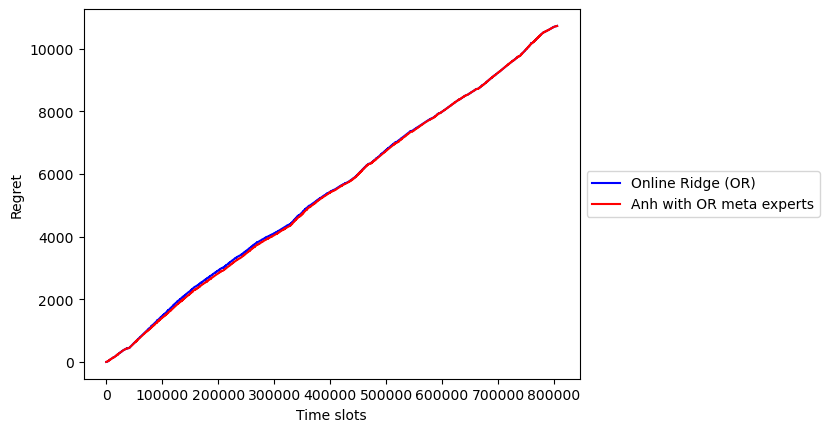

Group number 1, Tg is 763685 

    oridge end regret 8654.15, Anh end regret 8495.30, 

    Anh better Yes 


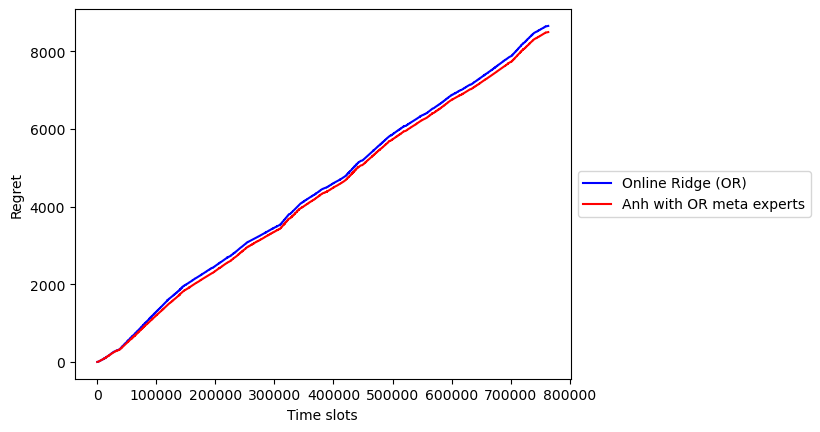

Group number 2, Tg is 1045807 

    oridge end regret 13679.61, Anh end regret 13577.46, 

    Anh better Yes 


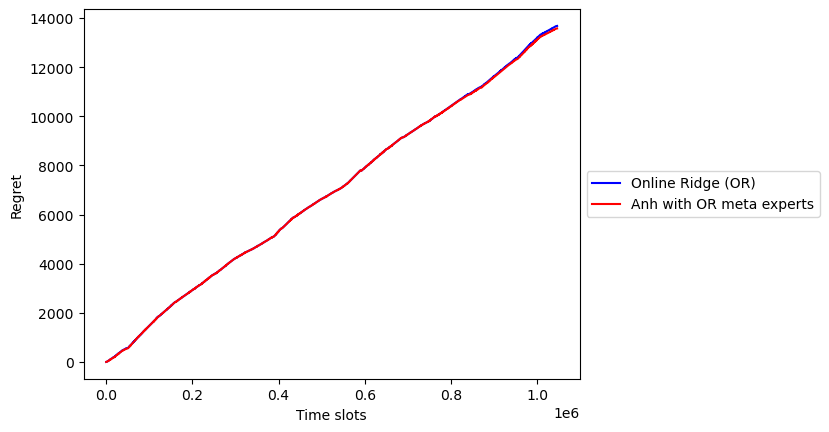

Group number 3, Tg is 136227 

    oridge end regret 1123.96, Anh end regret 1125.26, 

    Anh better No 


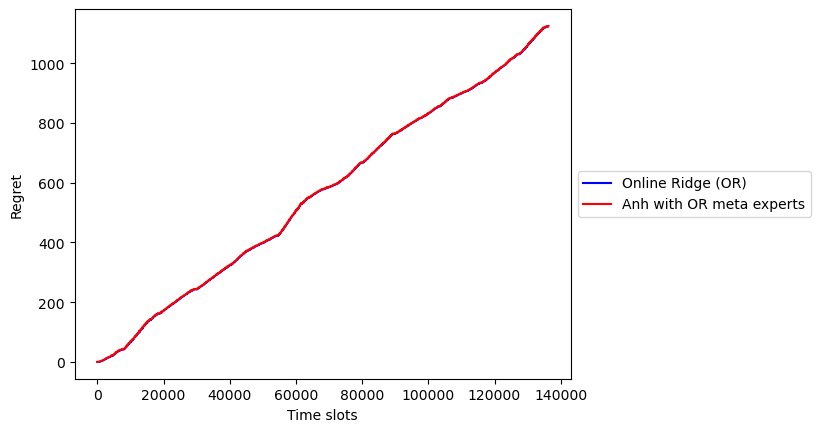

Group number 4, Tg is 14455 

    oridge end regret 96.65, Anh end regret 96.59, 

    Anh better Yes 


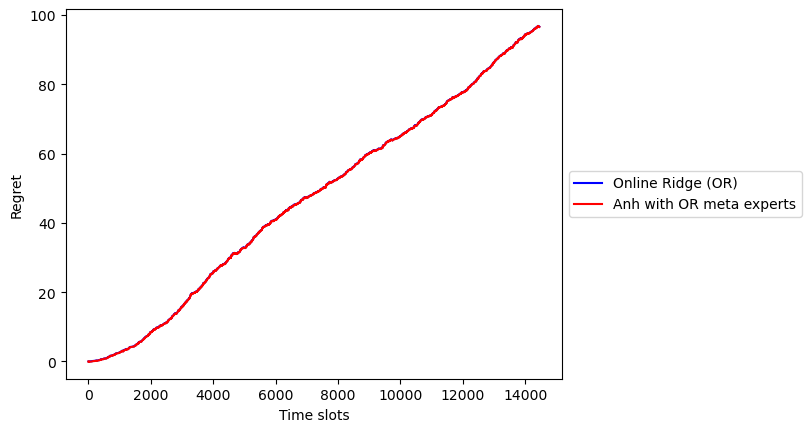

Group number 5, Tg is 726 

    oridge end regret 1.44, Anh end regret 1.44, 

    Anh better No 


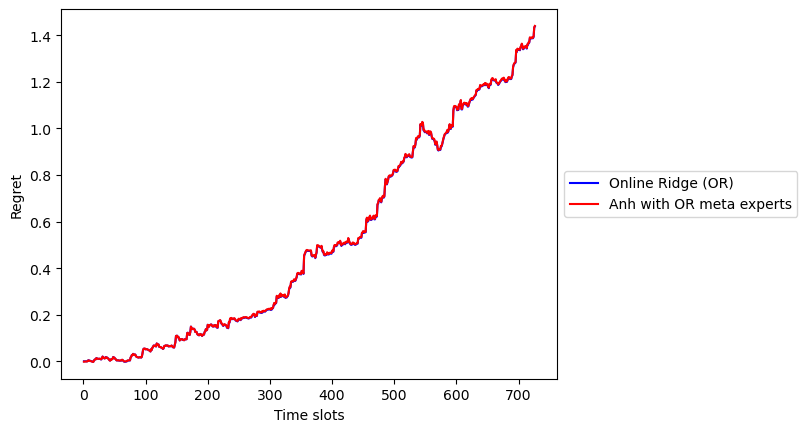

Group number 6, Tg is 2316 

    oridge end regret 13.01, Anh end regret 12.96, 

    Anh better Yes 


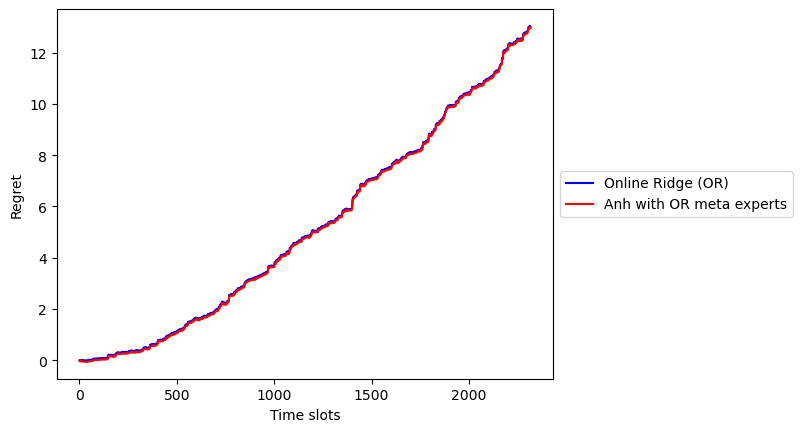

Group number 7, Tg is 100852 

    oridge end regret 1811.42, Anh end regret 1811.28, 

    Anh better Yes 


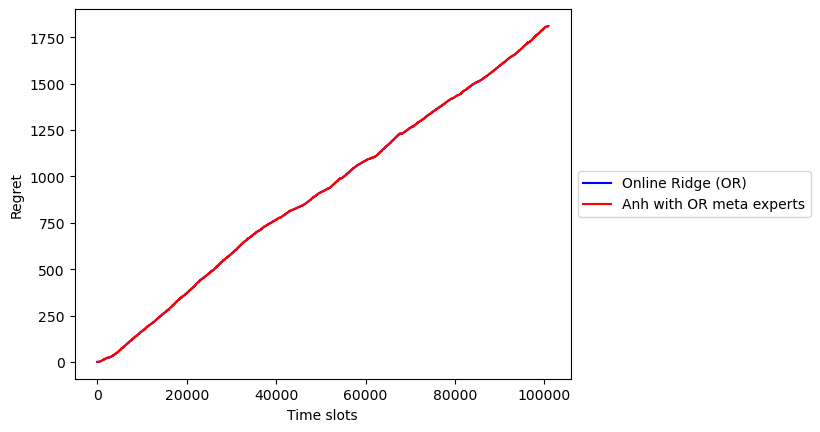

Group number 8, Tg is 2755 

    oridge end regret 14.57, Anh end regret 14.53, 

    Anh better Yes 


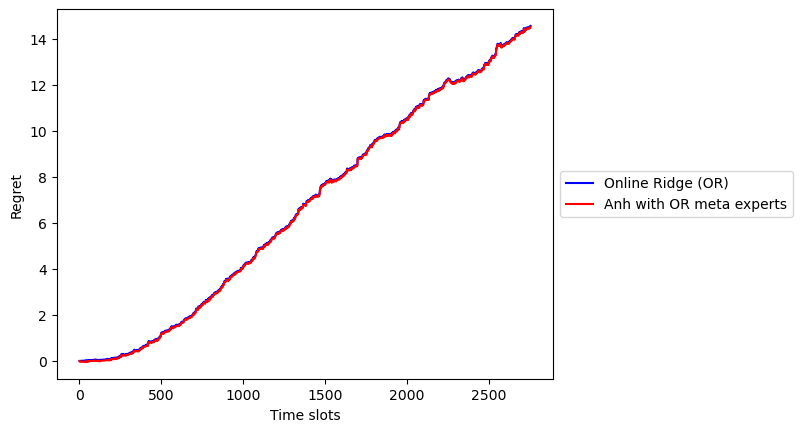

Group number 9, Tg is 97582 

    oridge end regret 690.98, Anh end regret 690.80, 

    Anh better Yes 


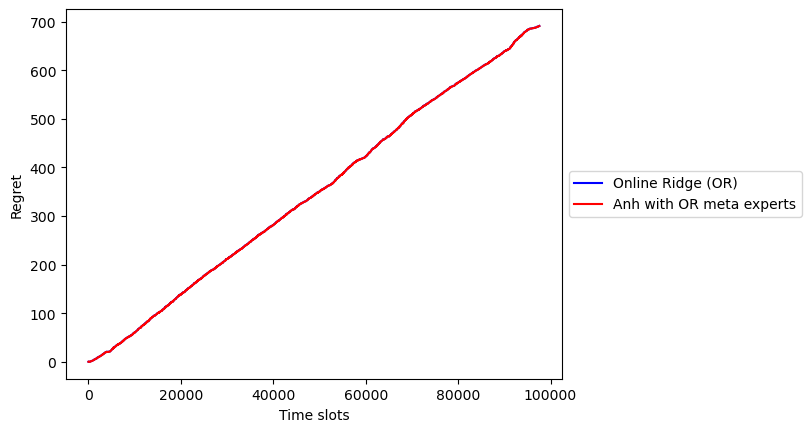

Group number 10, Tg is 168468 

    oridge end regret 1852.92, Anh end regret 1852.69, 

    Anh better Yes 


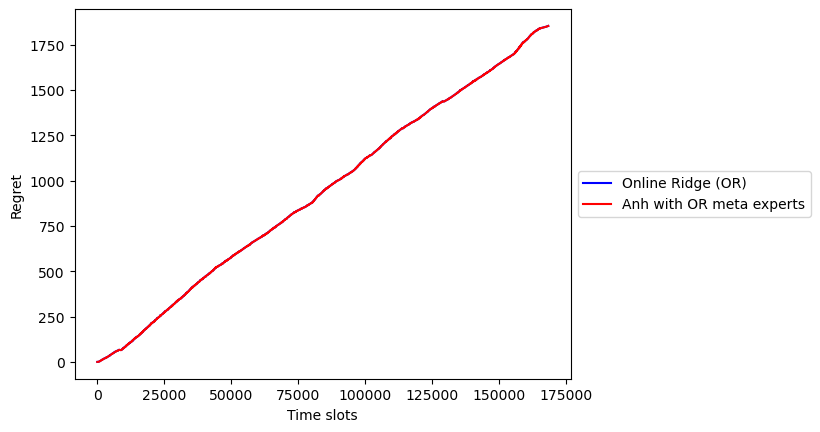

Group number 11, Tg is 1569188 

    oridge end regret 19969.37, Anh end regret 19054.96, 

    Anh better Yes 


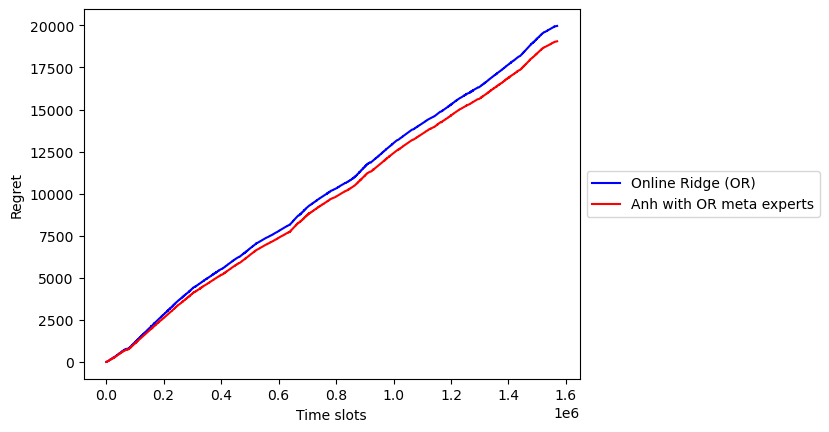

Anh better for 10 out of 12 groups


In [79]:
plot_ORidgevsAnh_together(cumreg_groupwise_ridgesubseq, Anh_undropped) # unimplementable ridge expert vs Anh

# Best least squares with dropped sensitive columns

- then on the dropped race and sex columns **df_te_scaled** but we drop the race and sex columns

In [80]:
# X_dat_te_scaled = df_te_scaled.drop('PINCP', axis=1) #dropping the income column
# y_dat_te_scaled = pd.DataFrame(df_te_scaled['PINCP']) # picking up only the income column for the target
sensitive_groups = ['SEX', 'RAC1P']
X_dat_te_drop =  X_dat_te_scaled.drop(sensitive_groups, axis=1)
y_dat_te_drop = y_dat_te_scaled

In [83]:
print(X_dat_te_drop.shape) # no RACE and SEX columns here
print(X_dat_te_scaled.shape)

(1569188, 12)
(1569188, 14)


In [84]:
bls_dropped = BestLS_Hindsight_Together(N)
for t in tqdm(range(T)):
  bls_dropped.update(A_t[t], X_dat_te_drop.iloc[[t]], y_dat_te_drop.iloc[t])

100%|██████████| 1569188/1569188 [28:48<00:00, 907.67it/s]  


In [88]:
for gnum in range(N): #made each internal array into numpy for faster joblib saves
    bls_dropped.loss_experts_arr[gnum] = np.array(bls_dropped.loss_experts_arr[gnum])

In [89]:
joblib.dump(bls_dropped, './target_encoded/models/bestsqloss/bls_dropped_15cols.pkl')

['./target_encoded/models/bestsqloss/bls_dropped_15cols.pkl']

In [103]:
bls_dropped.cumbestsqloss() # builds cumulative best sq loss 

# Ada normal hedge with ridge meta experts, dropped sensitive columns

In [94]:
experts = [River_OnlineRidge() for _ in range(N)] # Online ridge meta-experts
Anh_dropped = Adanormal_sleepingexps(N, experts) #adanormal hedge

# ONLINE INTERACTIONS!
for t in tqdm(range(T)):
  Anh_dropped.get_prob_over_experts(A_t[t]) #get probability over meta-experts
  Anh_dropped.update_metaexps_loss(A_t[t], X_dat_te_drop.iloc[[t]], y_dat_te_drop.iloc[t]) # update internal states of the meta-experts

100%|██████████| 1569188/1569188 [15:58<00:00, 1637.72it/s]


In [95]:
with open('./target_encoded/models/Anh/Anh_dropped_15cols.pkl', 'wb') as f:
    pickle.dump(Anh_dropped, f) #maybe numpying big arrays and then joblib can give faster save time?

In [97]:
Anh_dropped.cuml_regret_curve

[]

In [104]:
Anh_dropped.build_cumloss_curve(bls_dropped.best_sqloss, A_t) # build adanormal hedge cumregret curve

In [105]:
cumloss_groupwise_ridgesubseq = [] #online ridge cumulative regret, this is the non-implementable version
cumreg_groupwise_ridgesubseq = []

for gnum in range(N): # build cumulative loss for  on each group subsequence for seperate ridge expert
    cumloss_groupwise_ridgesubseq.append(np.cumsum(Anh_dropped.experts[gnum].loss_tarr)) #using Ada normal hedge experts ridge loss arrays
    cumreg_groupwise_ridgesubseq.append(cumloss_groupwise_ridgesubseq[-1] - bls_dropped.best_sqloss[gnum]) #bestsquare loss for that group subsequence still the same

Group number 0, Tg is 805503 

    oridge end regret 10720.37, Anh end regret 10719.58, 

    Anh better Yes 


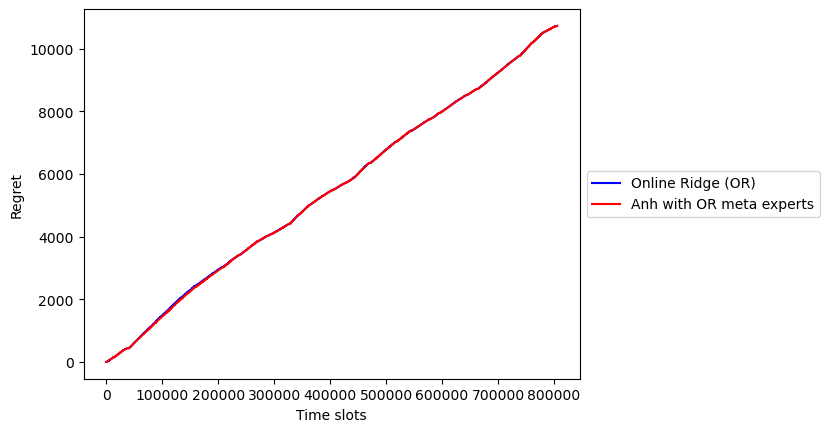

Group number 1, Tg is 763685 

    oridge end regret 8679.63, Anh end regret 8679.33, 

    Anh better Yes 


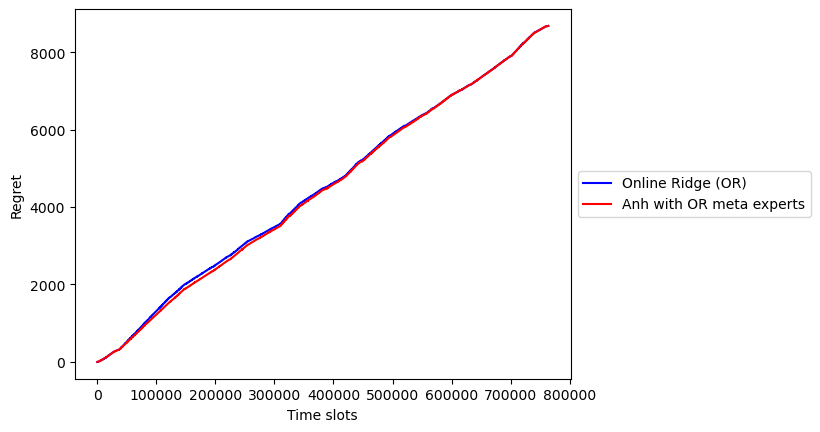

Group number 2, Tg is 1045807 

    oridge end regret 13900.53, Anh end regret 13026.32, 

    Anh better Yes 


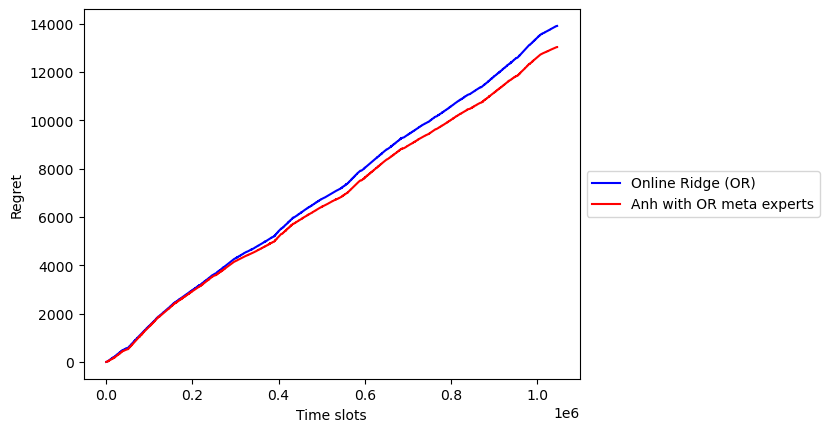

Group number 3, Tg is 136227 

    oridge end regret 1122.14, Anh end regret 1123.82, 

    Anh better No 


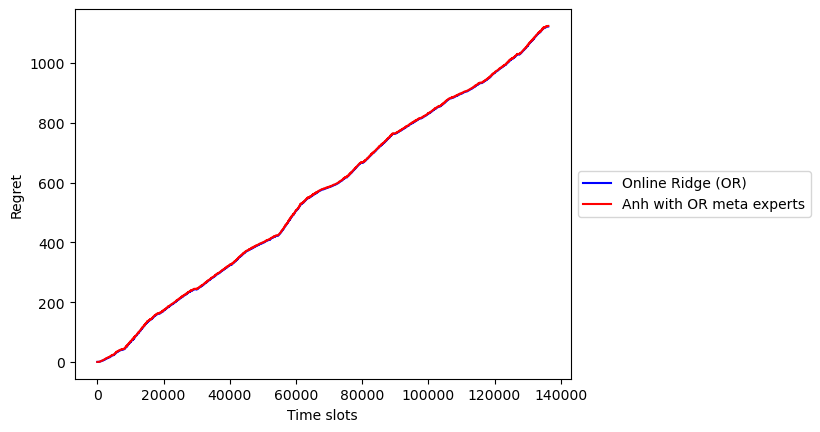

Group number 4, Tg is 14455 

    oridge end regret 97.40, Anh end regret 97.40, 

    Anh better No 


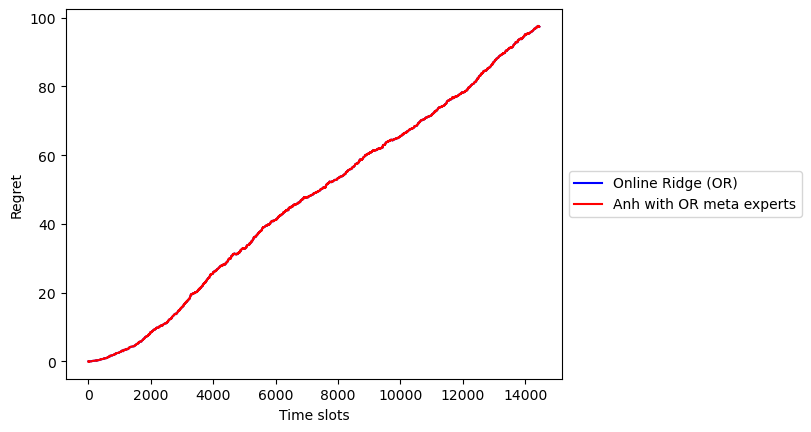

Group number 5, Tg is 726 

    oridge end regret 1.48, Anh end regret 1.50, 

    Anh better No 


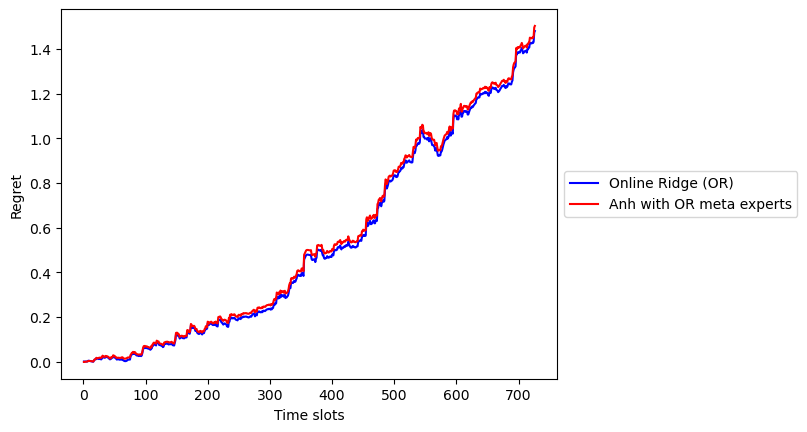

Group number 6, Tg is 2316 

    oridge end regret 13.02, Anh end regret 12.96, 

    Anh better Yes 


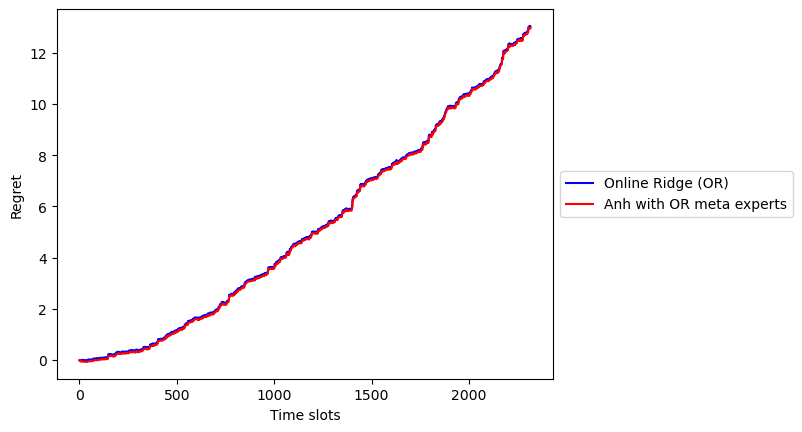

Group number 7, Tg is 100852 

    oridge end regret 1828.37, Anh end regret 1827.98, 

    Anh better Yes 


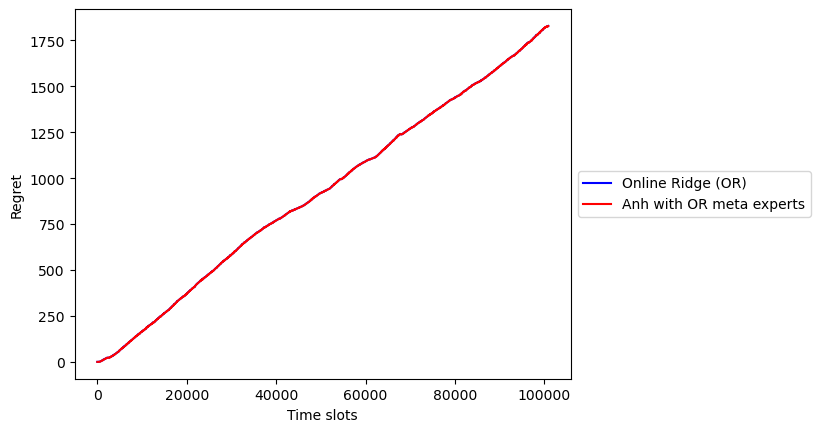

Group number 8, Tg is 2755 

    oridge end regret 14.68, Anh end regret 14.62, 

    Anh better Yes 


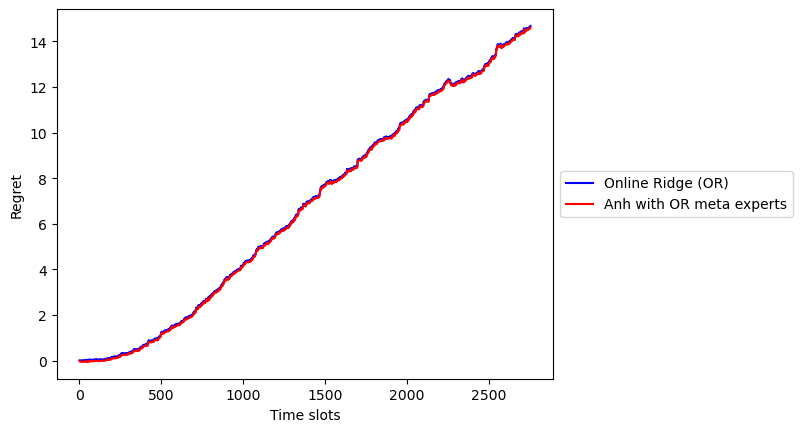

Group number 9, Tg is 97582 

    oridge end regret 701.91, Anh end regret 701.89, 

    Anh better Yes 


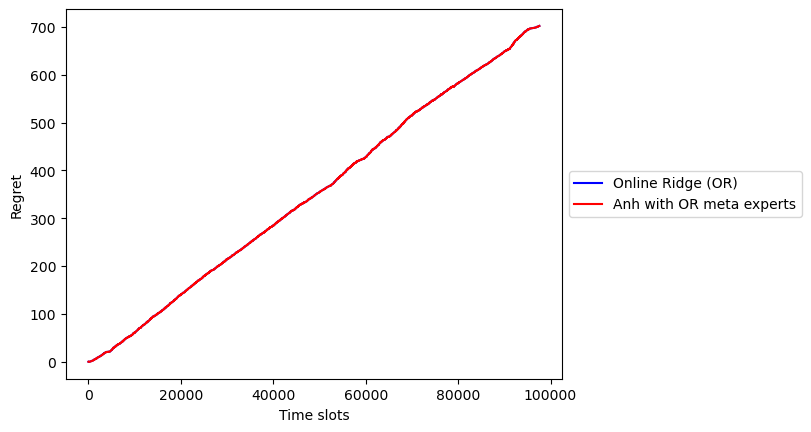

Group number 10, Tg is 168468 

    oridge end regret 1869.19, Anh end regret 1868.94, 

    Anh better Yes 


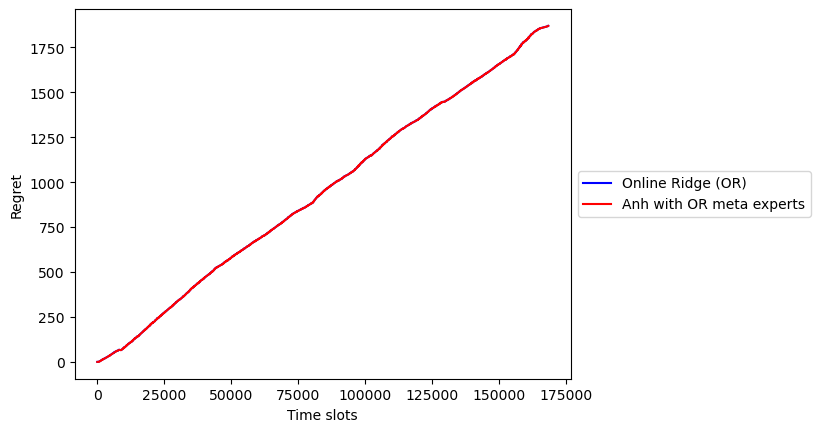

Group number 11, Tg is 1569188 

    oridge end regret 20389.67, Anh end regret 18538.52, 

    Anh better Yes 


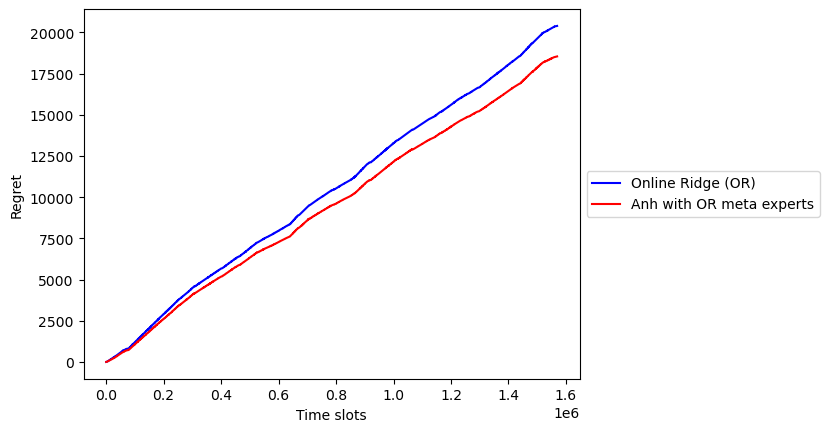

Anh better for 9 out of 12 groups


In [106]:
plot_ORidgevsAnh_together(cumreg_groupwise_ridgesubseq, Anh_dropped)

# Single online ridge which is always active on dropped columns, (implementable)

In [ ]:
# or_implementable_undropped = OnlineRidgeImplementable_alwaysactive(X_dat_te_scaled, y_dat_te_scaled) # undropped columns
# with open('./target_encoded/models/oridge_implementable/oridge_undropped15col.pkl', 'wb') as f:
#     pickle.dump(or_implementable_undropped, f)

# or_implementable_dropped = OnlineRidgeImplementable_alwaysactive(X_dat_te_drop, y_dat_te_drop) # undropped columns
# with open('./target_encoded/models/oridge_implementable/oridge_dropped15col.pkl', 'wb') as f:
#     pickle.dump(or_implementable_dropped, f)

# Below we compare performance of Implementable Oridge (always active), with undropped columns  V/S  Ada normal hedge with undropped columns

In [111]:
with open('./target_encoded/models/oridge_implementable/oridge_undropped15col.pkl', 'rb') as f:
    or_implementable_undropped = pickle.load(f)

or_implementable_undropped.fill_subsequence_regrets(A_t, bls_undropped.best_sqloss) # fill subsequence regrets for implementable algorithm

Group number 0, Tg is 805503 

    oridge end regret 11440.05, Anh end regret 10729.69, 

    Anh better Yes 


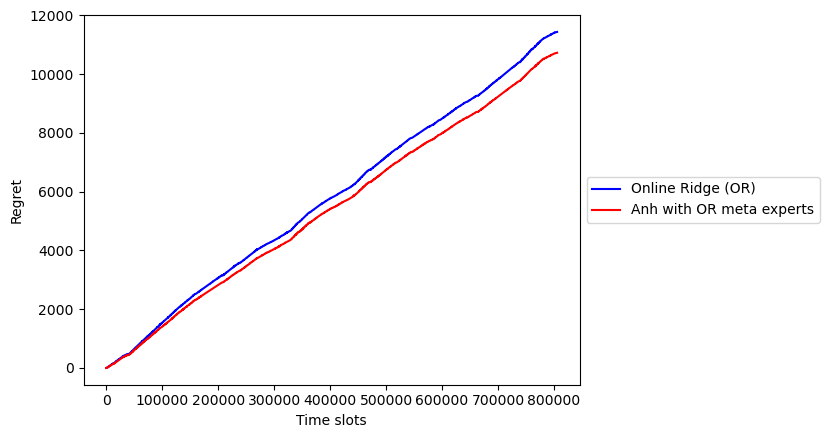

Group number 1, Tg is 763685 

    oridge end regret 8695.52, Anh end regret 8495.30, 

    Anh better Yes 


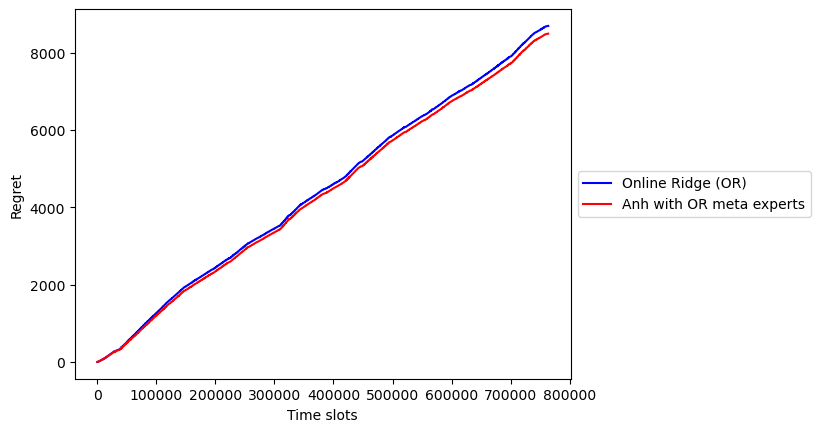

Group number 2, Tg is 1045807 

    oridge end regret 13963.35, Anh end regret 13577.46, 

    Anh better Yes 


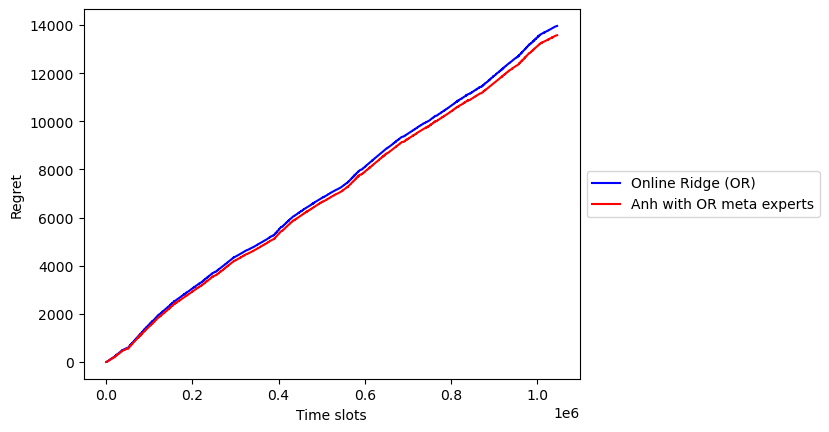

Group number 3, Tg is 136227 

    oridge end regret 1186.45, Anh end regret 1125.26, 

    Anh better Yes 


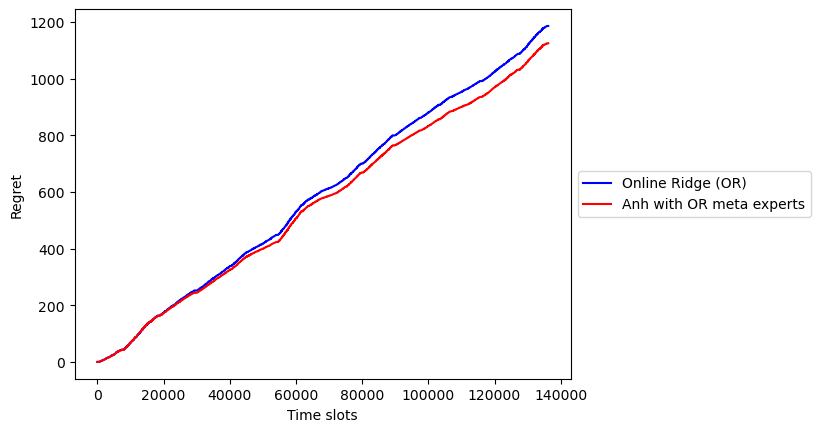

Group number 4, Tg is 14455 

    oridge end regret 110.75, Anh end regret 96.59, 

    Anh better Yes 


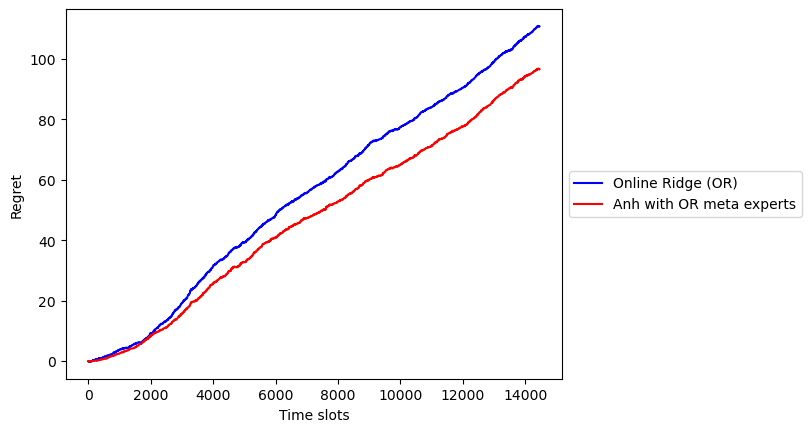

Group number 5, Tg is 726 

    oridge end regret 3.16, Anh end regret 1.44, 

    Anh better Yes 


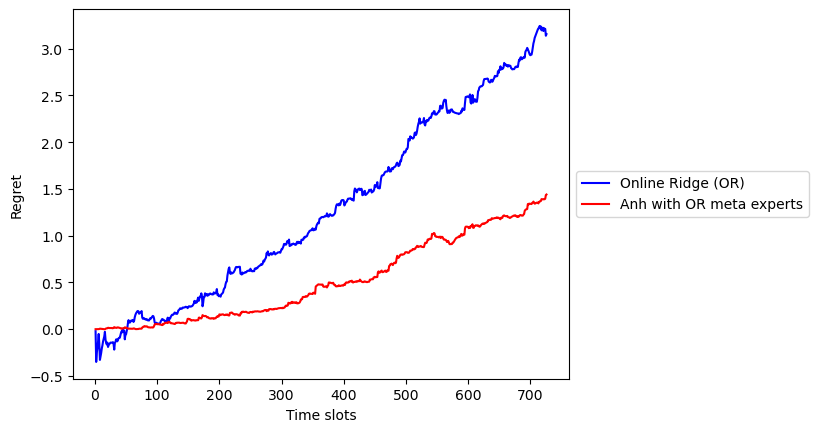

Group number 6, Tg is 2316 

    oridge end regret 16.45, Anh end regret 12.96, 

    Anh better Yes 


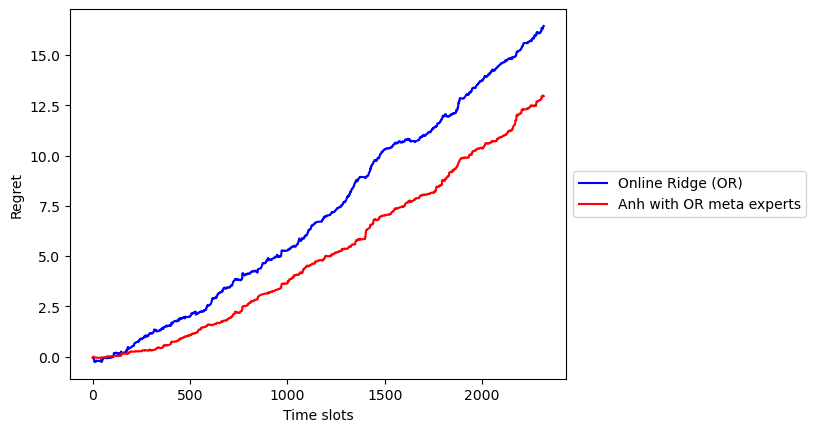

Group number 7, Tg is 100852 

    oridge end regret 1946.96, Anh end regret 1811.28, 

    Anh better Yes 


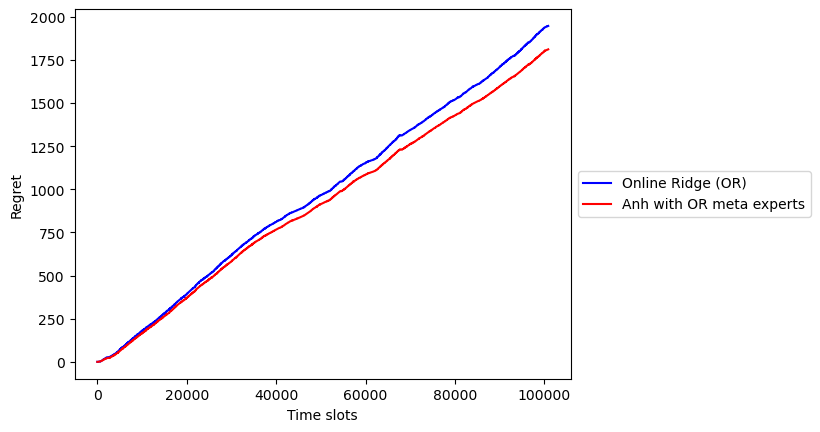

Group number 8, Tg is 2755 

    oridge end regret 16.98, Anh end regret 14.53, 

    Anh better Yes 


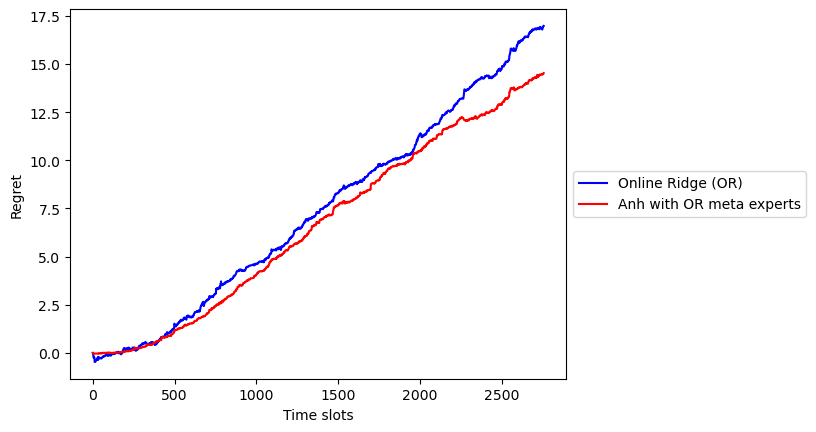

Group number 9, Tg is 97582 

    oridge end regret 908.16, Anh end regret 690.80, 

    Anh better Yes 


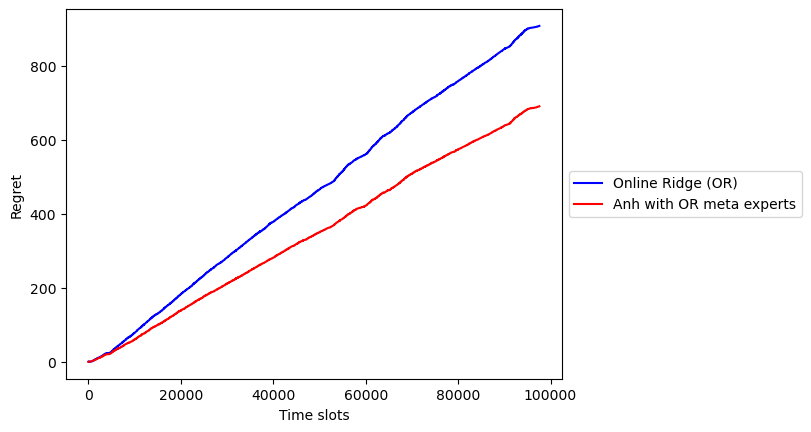

Group number 10, Tg is 168468 

    oridge end regret 1941.33, Anh end regret 1852.69, 

    Anh better Yes 


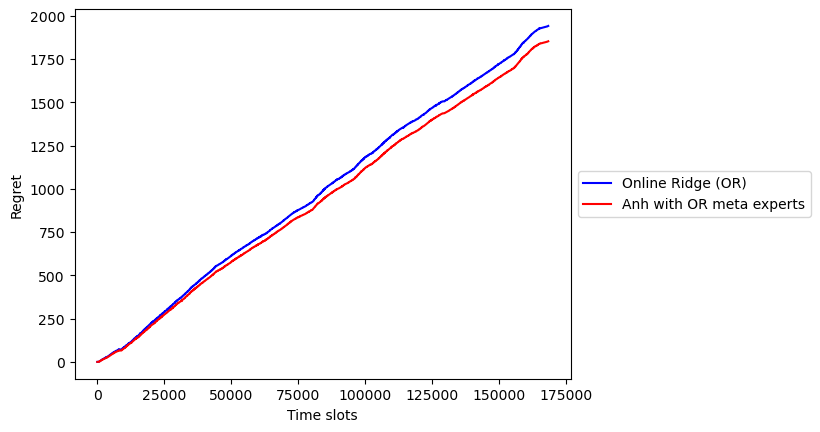

Group number 11, Tg is 1569188 

    oridge end regret 19965.53, Anh end regret 19054.96, 

    Anh better Yes 


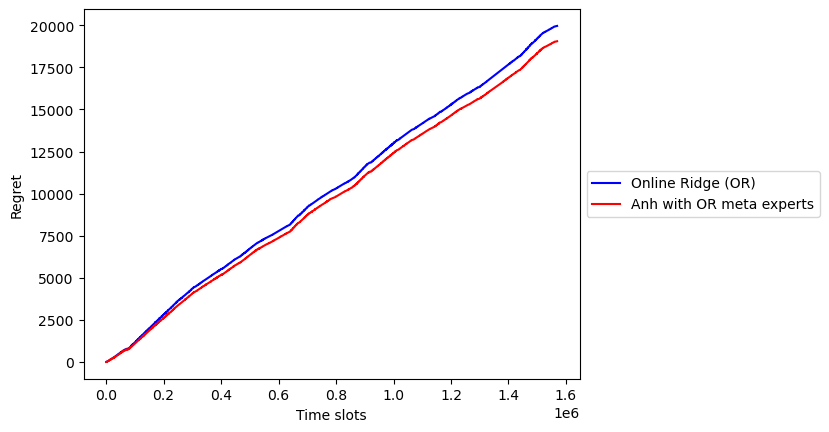

Anh better for 12 out of 12 groups


In [113]:
plot_ORidgevsAnh_together(or_implementable_undropped.cumreg_groupwise_oridge, Anh_undropped)

# Below we compare performance of Implementable Oridge (always active), with dropped columns  V/S  Ada normal hedge with dropped columns

In [114]:
with open('./target_encoded/models/oridge_implementable/oridge_dropped15col.pkl', 'rb') as f:
    or_implementable_dropped = pickle.load(f)

In [116]:
or_implementable_dropped.fill_subsequence_regrets(A_t, bls_dropped.best_sqloss) # fill subsequence regrets for implementable algorithm

Group number 0, Tg is 805503 

    oridge end regret 11973.80, Anh end regret 10719.58, 

    Anh better Yes 


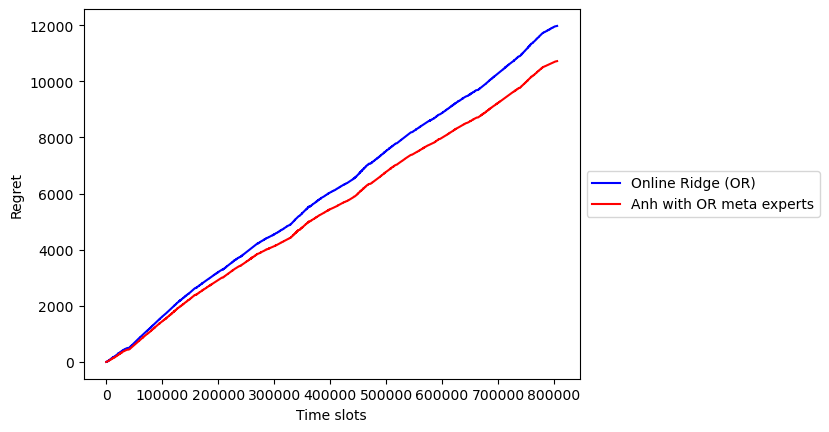

Group number 1, Tg is 763685 

    oridge end regret 9296.77, Anh end regret 8679.33, 

    Anh better Yes 


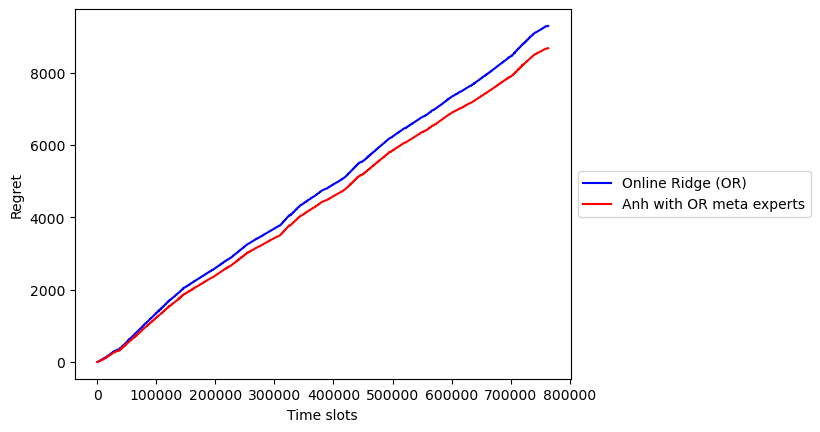

Group number 2, Tg is 1045807 

    oridge end regret 14151.28, Anh end regret 13026.32, 

    Anh better Yes 


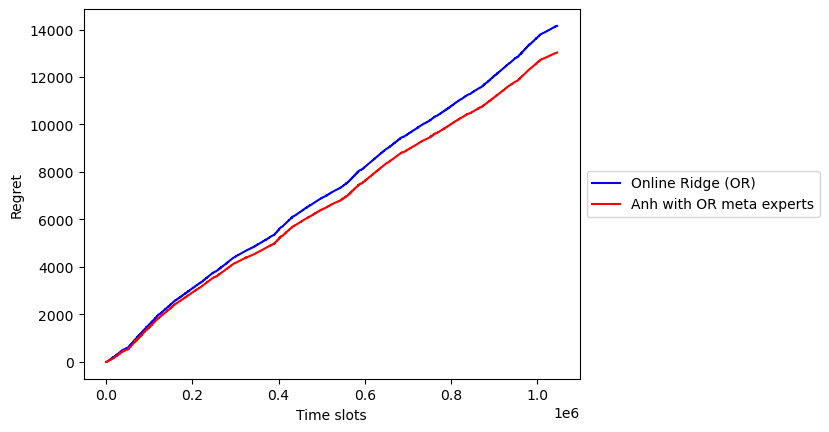

Group number 3, Tg is 136227 

    oridge end regret 1232.70, Anh end regret 1123.82, 

    Anh better Yes 


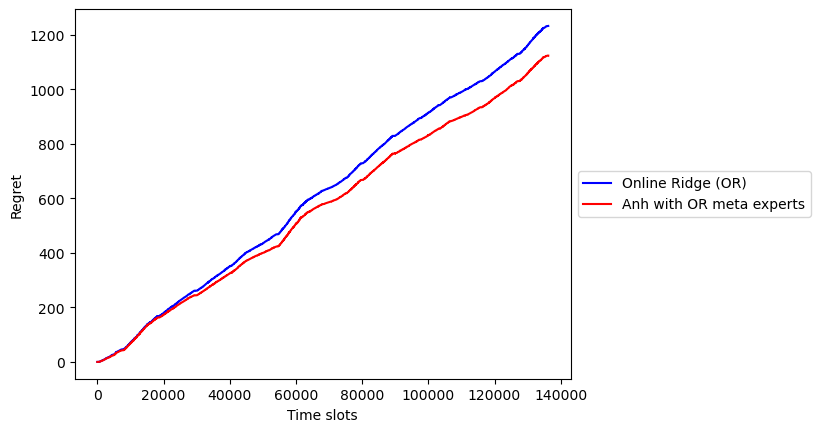

Group number 4, Tg is 14455 

    oridge end regret 120.03, Anh end regret 97.40, 

    Anh better Yes 


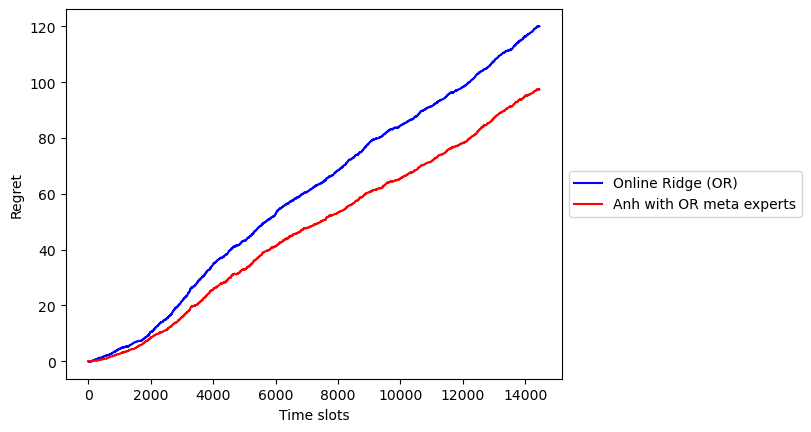

Group number 5, Tg is 726 

    oridge end regret 3.82, Anh end regret 1.50, 

    Anh better Yes 


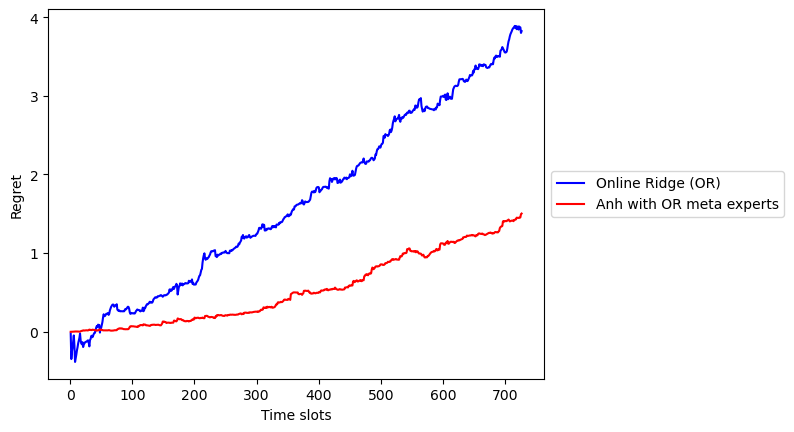

Group number 6, Tg is 2316 

    oridge end regret 18.16, Anh end regret 12.96, 

    Anh better Yes 


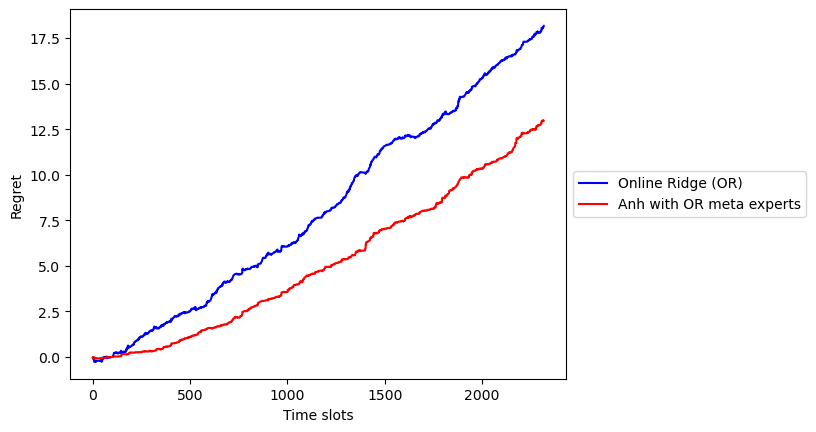

Group number 7, Tg is 100852 

    oridge end regret 2009.39, Anh end regret 1827.98, 

    Anh better Yes 


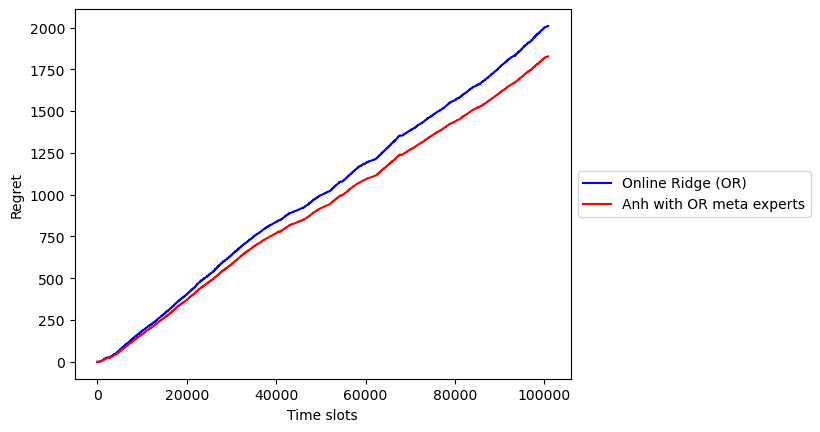

Group number 8, Tg is 2755 

    oridge end regret 17.84, Anh end regret 14.62, 

    Anh better Yes 


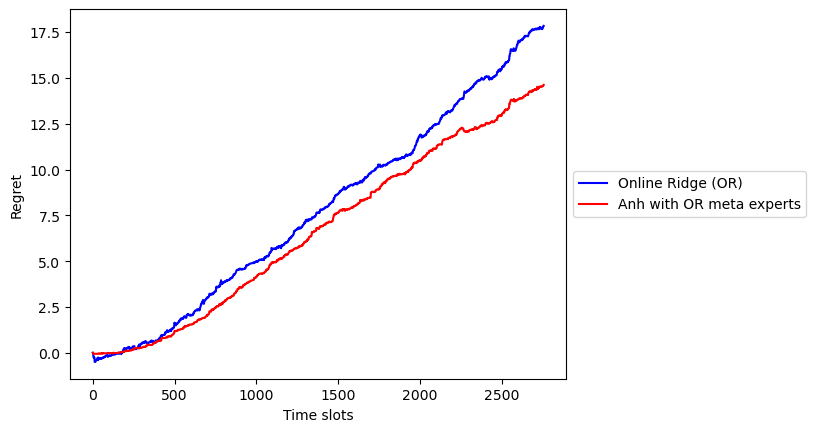

Group number 9, Tg is 97582 

    oridge end regret 1001.24, Anh end regret 701.89, 

    Anh better Yes 


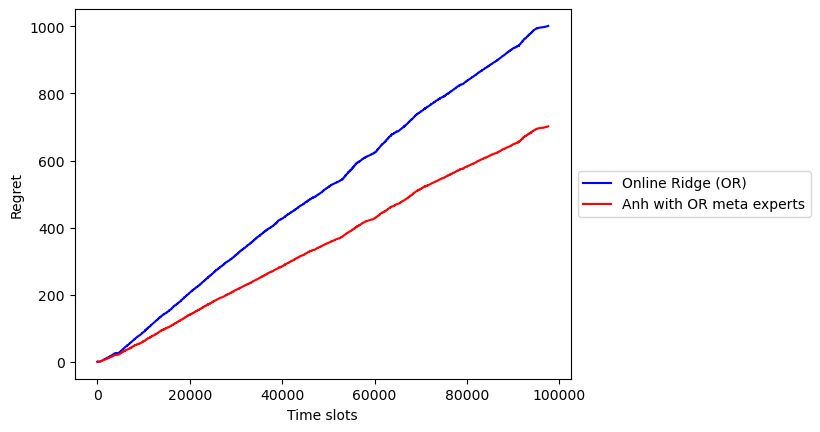

Group number 10, Tg is 168468 

    oridge end regret 1992.62, Anh end regret 1868.94, 

    Anh better Yes 


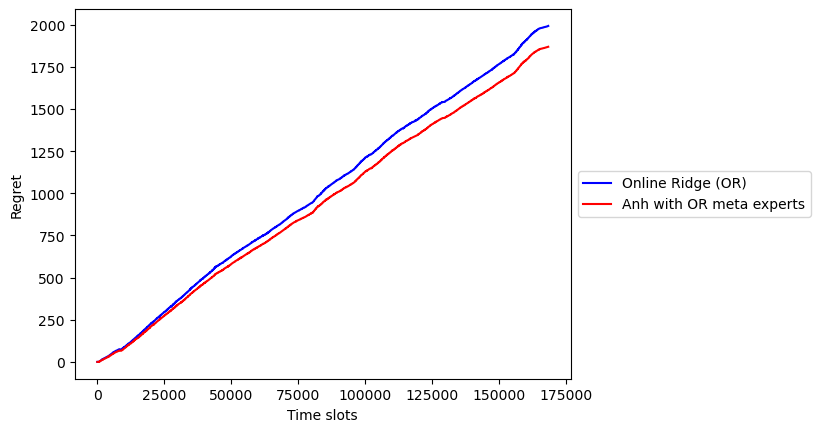

Group number 11, Tg is 1569188 

    oridge end regret 20410.18, Anh end regret 18538.52, 

    Anh better Yes 


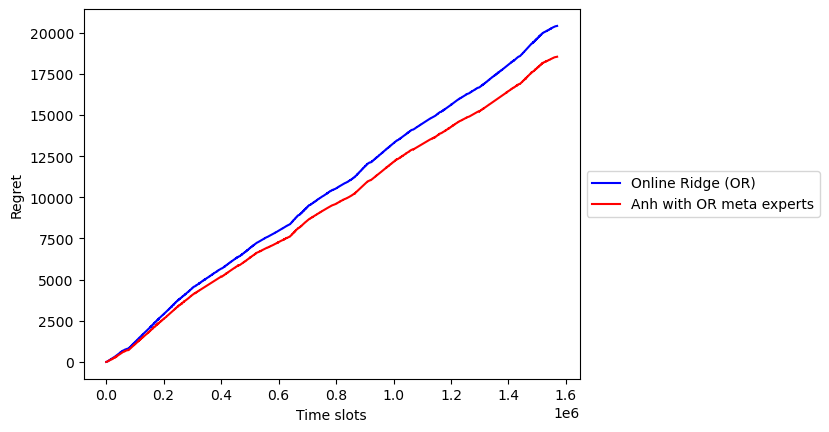

Anh better for 12 out of 12 groups


In [118]:
plot_ORidgevsAnh_together(or_implementable_dropped.cumreg_groupwise_oridge, Anh_dropped)

In [4]:
with open('./target_encoded/models/Anh/Anh_undropped_15cols.pkl', 'rb') as f:
    Anh = pickle.load(f)

In [6]:
A_t = np.load('./target_encoded/nparrays/A_t12groups.npy')
N = A_t.shape[1]

In [8]:
import joblib
bls_undropped = joblib.load('./target_encoded/models/bestsqloss/bls_undropped_15cols.pkl')

In [10]:
bls_undropped.cumbestsqloss()

In [12]:
Anh.build_cumloss_curve(bls_undropped.best_sqloss, A_t)

In [22]:
#cleaning up and reducing size for saving, TODO add as a method in lean_adahedge.py

# Anh.experts = None # dont set this to None as its required to find ridge expert non-implementables loss!
Anh.proboverexps_tarr = None
Anh.loss_vec_tarr = None
Anh.loss_ada_tarr = None

Anh.cuml_loss_adagroup_tarr = None

# defintely None for these 3 as only used internally
Anh.inst_reg_tarr = None
Anh.cuml_reg_tarr = None
Anh.abs_reg_tarr = None


# Also make numpy array out of cuml_loss_curve and cuml_regret_curve, important to make each element inside the list a numpy array, inhomogenous shape if directly to numpy array
# Anh.cuml_loss_curve = np.array(Anh.cuml_loss_curve)
# Anh.cuml_regret_curve = np.array(Anh.cuml_regret_curve)

for gnum in range(N):
    Anh.cuml_loss_curve[gnum] = np.array(Anh.cuml_loss_curve[gnum])
    Anh.cuml_regret_curve[gnum] = np.array(Anh.cuml_regret_curve[gnum])


In [23]:
joblib.dump(Anh, './target_encoded/models/Anh/Anh_undropped_15cols_compact.pkl')

['./target_encoded/models/Anh/Anh_undropped_15cols_compact.pkl']

In [17]:
type(Anh.cuml_loss_curve)

list